In [1]:
import pandas as pd
import numpy as np

import cv2
import os
import random
from PIL import Image
from tqdm import tqdm
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import tensorflow as tf

In [12]:
images_list = []
hotel_list = [10129, 310173]
for hotel in hotel_list:
    l = len(os.listdir(f"AML/HotelTraffickingData/horizaontal/train/{hotel}/"))
    for i in range(l):
        data = (f"AML/HotelTraffickingData/horizaontal/train/{hotel}/{i}.png", f"AML/HotelTraffickingData/vertical/train/{hotel}/{i}.png", hotel)
        images_list.append(data)

for hotel in hotel_list:
    l = len(os.listdir(f"AML/HotelTraffickingData/horizaontal/val/{hotel}/"))
    for i in range(l):
        data = (f"AML/HotelTraffickingData/horizaontal/val/{hotel}/{i}.png", f"AML/HotelTraffickingData/vertical/val/{hotel}/{i}.png", hotel)
        images_list.append(data)

for hotel in hotel_list:
    l = len(os.listdir(f"AML/HotelTraffickingData/horizaontal/test/{hotel}/"))
    for i in range(l):
        data = (f"AML/HotelTraffickingData/horizaontal/test/{hotel}/{i}.png", f"AML/HotelTraffickingData/vertical/test/{hotel}/{i}.png", hotel)
        images_list.append(data)

random.shuffle(images_list)

try:
    os.mkdir("AML/HotelTraffickingData/New Data/")
    os.mkdir("AML/HotelTraffickingData/New Data/train")
    os.mkdir("AML/HotelTraffickingData/New Data/val")
    os.mkdir("AML/HotelTraffickingData/New Data/test")
except FileExistsError:
    pass

for hotel in hotel_list:
    try:
        os.mkdir(f"AML/HotelTraffickingData/New Data/train/{hotel}")
        os.mkdir(f"AML/HotelTraffickingData/New Data/val/{hotel}")
        os.mkdir(f"AML/HotelTraffickingData/New Data/test/{hotel}")
    except FileExistsError:
        pass

for images in tqdm(images_list):
    image_p1, image_p2, label = images
    # print(images)
    im1 = Image.open(image_p1)
    im2 = Image.open(image_p2)
    image = Image.blend(im1, im2, 0.5)

    image_p1 = image_p1.split("/")
    h = image_p1[-2] 
    n = image_p1[-1].split(".")[0]
    k = image_p1[-3]

    image.save(f"AML/HotelTraffickingData/New Data/{k}/{h}/{n}.png")
    image = cv2.imread(f"AML/HotelTraffickingData/New Data/{k}/{h}/{n}.png")
    image = cv2.resize(image, (256, 256))
    cv2.imwrite(f"AML/HotelTraffickingData/New Data/{k}/{h}/{n}.png", image)

100%|██████████| 20000/20000 [1:50:10<00:00,  3.03it/s]


In [2]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "AML/HotelTraffickingData/New Data/train",
  image_size=(256, 256),
  batch_size=32,
  labels='inferred',
  label_mode='int'
)

val_ds= tf.keras.preprocessing.image_dataset_from_directory(
  "AML/HotelTraffickingData/New Data/val",
  image_size=(256, 256),
  batch_size=32,
  labels='inferred',
  label_mode='int'
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "AML/HotelTraffickingData/New Data/test",
  image_size=(256, 256),
  batch_size=32,
  labels='inferred',
  label_mode='int'
)

Found 13600 files belonging to 2 classes.
Found 2400 files belonging to 2 classes.
Found 4000 files belonging to 2 classes.


In [3]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),

    tf.keras.layers.MaxPooling2D(strides=(2, 2)),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),

    tf.keras.layers.MaxPooling2D(strides=(2, 2)),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),

    tf.keras.layers.MaxPooling2D(strides=(2, 2)),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

tf.keras.utils.plot_model(model, show_layer_names = False, show_shapes = True)



You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [4]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['Accuracy']
)

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 250, 250, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 125, 125, 64)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 125, 125, 64)      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 123, 123, 128)     73856     
                                                        

In [6]:
epochs=10
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[callback]
)

Epoch 1/10



c:\Users\shara\OneDrive\Desktop\AML\IM_Resize\.venv\Lib\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(



425/425 [==============================] - 4238s 10s/step - loss: 4.5429 - Accuracy: 0.8033 - val_loss: 0.2437 - val_Accuracy: 0.8996
Epoch 2/10
425/425 [==============================] - 3854s 9s/step - loss: 0.1109 - Accuracy: 0.9621 - val_loss: 0.1352 - val_Accuracy: 0.9621
Epoch 3/10
425/425 [==============================] - 3888s 9s/step - loss: 0.0671 - Accuracy: 0.9787 - val_loss: 0.0542 - val_Accuracy: 0.9792
Epoch 4/10
425/425 [==============================] - 3880s 9s/step - loss: 0.0458 - Accuracy: 0.9859 - val_loss: 0.0314 - val_Accuracy: 0.9904
Epoch 5/10
425/425 [==============================] - 3873s 9s/step - loss: 0.0392 - Accuracy: 0.9882 - val_loss: 0.0253 - val_Accuracy: 0.9925
Epoch 6/10
425/425 [==============================] - 3857s 9s/step - loss: 0.0360 - Accuracy: 0.9887 - val_loss: 0.0151 - val_Accuracy: 0.9962
Epoch 7/10
425/425 [==============================] - 3849s 9s/step - loss: 0.0343 - Accuracy: 0.9890 - val_loss: 0.0398 - val_Accuracy: 0.9854
E

In [7]:
model.save("model.tf")

INFO:tensorflow:Assets written to: model.tf\assets


INFO:tensorflow:Assets written to: model.tf\assets


In [8]:
output = model.predict(test_ds)

125/125 [==============================] - 202s 2s/step


In [10]:
np.argmax(output, axis = 1)

array([0, 1, 0, ..., 1, 1, 0], dtype=int64)

In [9]:
output

array([[7.9811025e-01, 2.0188972e-01],
       [1.7720664e-06, 9.9999821e-01],
       [9.0740019e-01, 9.2599832e-02],
       ...,
       [9.4612013e-04, 9.9905390e-01],
       [4.7908141e-04, 9.9952090e-01],
       [9.9995947e-01, 4.0517774e-05]], dtype=float32)

In [12]:
test_ds.class_names

['10129', '310173']

In [27]:
class_label = []
for item in test_ds:
    output = np.argmax(model.predict(item[0]), axis = 1)
    # print(output)
    # print(item[1])
    # break
    class_label.append([output, item[1].numpy()])
print(class_label)

1/1 [==============================] - 1s 1s/step
[[array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 0], dtype=int64), array([1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 0])], [array([0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1], dtype=int64), array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1])], [array([0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 1], dtype=int64), array([0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 1])], [array([0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 0], dtype=int64), array([0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 0,

In [28]:
class_label[0]

[array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1,
        0, 1, 0, 1, 0, 0, 1, 1, 1, 0], dtype=int64),
 array([1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1,
        0, 1, 0, 1, 0, 0, 1, 1, 1, 0])]

In [30]:
testsamples = []
for row in class_label:
    n = len(row[0])
    for i in range(n):
        testsamples.append([row[0][i], row[1][i]])
    

In [32]:
testsamples = pd.DataFrame(testsamples, columns = ["Predicted", "Actual"])
testsamples

,Predicted,Actual
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
...,...,...
3995,0,0
3996,0,0
3997,1,1
3998,0,0


In [42]:
testsamples.to_csv("TestSamples.csv", index = False)

In [34]:
from sklearn.metrics import accuracy_score

score = accuracy_score(testsamples["Actual"], testsamples["Predicted"])
print(score)

0.9615


In [37]:
!pip install matplotlib

     ---------------------------------------- 7.6/7.6 MB 22.3 MB/s eta 0:00:00
     ------------------------------------- 187.6/187.6 kB 11.1 MB/s eta 0:00:00
     ---------------------------------------- 2.2/2.2 MB 27.6 MB/s eta 0:00:00
     ---------------------------------------- 56.1/56.1 kB ? eta 0:00:00



[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [38]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt

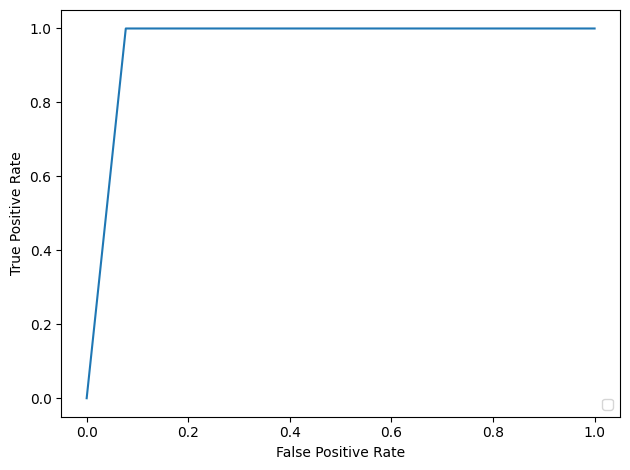

In [41]:
# Test Data
fpr, tpr, _ = roc_curve(np.array(testsamples["Actual"]).reshape(-1,1), np.array(testsamples["Predicted"]).reshape(-1,1))
roc_auc = auc(fpr, tpr)
# roc_curves_test[classifier_names[i]] = (fpr, tpr)
# auc_scores_test[classifier_names[i]] = roc_auc
plt.plot(fpr, tpr)

plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.tight_layout()
plt.show()

In [40]:
print(fpr)

[0.    0.077 1.   ]


In [50]:
history.history.keys()

dict_keys(['loss', 'Accuracy', 'val_loss', 'val_Accuracy'])

In [65]:
history.history["val_Accuracy"]

[0.8995833396911621,
 0.9620833396911621,
 0.9791666865348816,
 0.9904166460037231,
 0.9925000071525574,
 0.9962499737739563,
 0.9854166507720947,
 0.9887499809265137,
 0.98458331823349,
 0.9670833349227905]

In [56]:
!pip install seaborn

     -------------------------------------- 294.6/294.6 kB 9.2 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [57]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

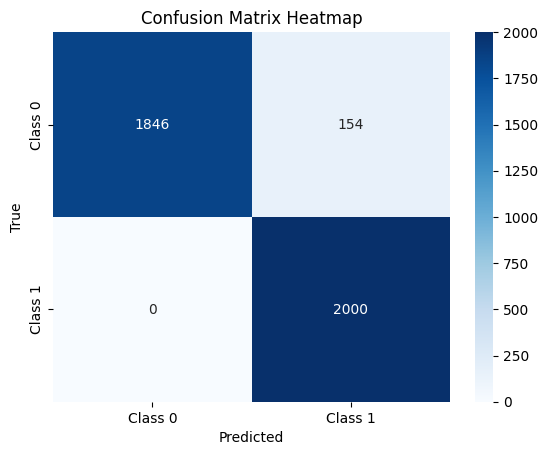

In [58]:
conf_mat = confusion_matrix(testsamples["Actual"], testsamples["Predicted"])
# Plot confusion matrix as a heatmap
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')

# Show plot
plt.show()

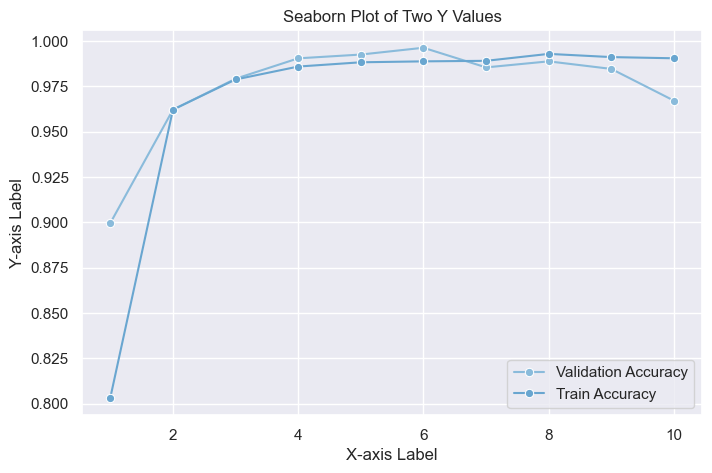

In [76]:
eps = [1,2,3,4,5,6,7,8,9,10]

sns.set(style="darkgrid", palette="Blues_d")
plt.figure(figsize=(8, 5))
sns.lineplot(x=eps, y= history.history["val_Accuracy"], label='Validation Accuracy', marker = "o")
sns.lineplot(x=eps, y=history.history["Accuracy"], label='Train Accuracy', marker = "o")

# Add labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Seaborn Plot of Two Y Values')

# Show legend
plt.legend()

# Show the plot
plt.show()